Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Assay Information
Hepatic metabolic stability is a key pharmacokinetic parameter in drug discovery. Metabolic stability is usually assessed in microsomal fractions and only the best compounds progress in the drug discovery process. A high-throughput single time point substrate depletion method in rat liver microsomes (RLM) is employed at the National Center for Advancing Translational Sciences (NCATS) as a Tier 1 assay. Between 2012 and 2020, RLM stability (in vitro half-life) data was generated for ~24,000 compounds from more than 250 NCATS projects that cover a wide range of pharmacological targets and cellular pathways. Data for ~2500 compounds along with the global prediction models are publicly available.

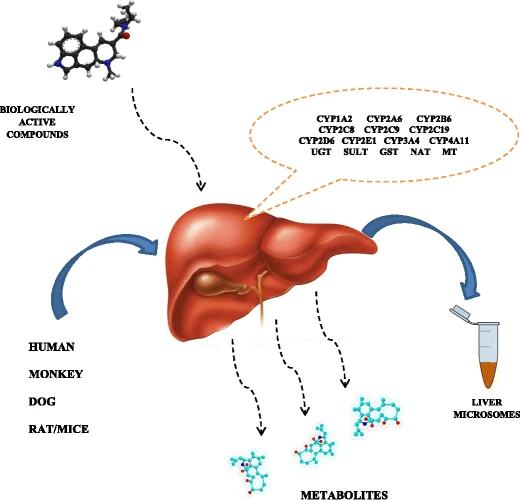

Image is from [this paper](https://link.springer.com/article/10.1007/s00216-016-9929-6). Biologically active compounds can be transformed or destroyed by the action of enzymes in the liver. Microsomes are small membrane bubbles (vesicles) that come from a fragmented cell membrane, and can be used as a proxy for how well a drug survives a trip through the liver.

## Description of readout:
- **HLM_CLEARANCE**: Intrinsic clearance measured in human liver microsomes following incubation at 37C. Experimental range <3 to >150 microL/min/mg. Rapid Commun. Mass Spectrom. 2010, 24, 1730-1736.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301370/

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import datamol as dm

from polaris import curation
from polaris.curation.viz_utils import visualize_distribution
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner

import tempfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can get the dataset directly from ChEMBL (https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/ gives the overall experimental data information, and subsequent numbers give data for a specific endpoint). The following map gives information on each:

In [3]:
# chembl_map = {
#     'CHEMBL3301362' : 'Most basic pKa value (pKa B1)', # 261
#     'CHEMBL3301363' : 'Octan-1-ol/water (pH7.4) distribution coefficent', # 4200
#     'CHEMBL3301364' : 'Solubility in pH7.4 buffer', #1763
#     'CHEMBL3301365' : '\% bound to plasma by equilibrium dialysis, human plasma', # PPB # 1614
#     'CHEMBL3301366' : '\% bound to plasma by equilibrium dialysis, rat plasma', # 717
#     'CHEMBL3301367' : '\% bound to plasma by equilibrium dialysis, dog plasma', # 244
#     'CHEMBL3301368' : '\% bound to plasma by equilibrium dialysis, mouse plasma', # 162
#     'CHEMBL3301369' : '\% bound to plasma by equilibrium dialysis, guinea pig plasma', # 91
#     'CHEMBL3301370' : 'Intrinsic clearance measured in human liver microsomes', #1102,
#     'CHEMBL3301371' : 'Intrinsic clearance measured in rat hepatocytes', # 837
#     'CHEMBL3301372' : 'Intrinsic clearance measured in human hepatocytes', # 408
# }

In [4]:
# load data
data = pd.read_parquet(
    "gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301370_raw.parquet"
)
data

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,14758721,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1,None,None,14758722,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
2,None,None,14758723,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
3,None,None,14758725,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
4,None,None,14758726,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,None,None,14769885,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1098,None,None,14769886,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1099,None,None,14769887,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1100,None,None,14769888,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [5]:
print(data.columns)

columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "HLM_CLEARANCE",
    }
)

data

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


,SMILES,HLM_CLEARANCE
0,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O,3.0
1,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,3.0
2,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,3.0
3,Cc1cc(C)nc(SCC(N)=O)n1,3.0
4,CN1CCN(CC(=O)N2c3ccccc3C(=O)Nc3cccnc32)CC1,3.0
...,...,...
1097,O=C(NCCc1ccccc1)c1cc(-n2ncc(=O)[nH]c2=O)ccc1Cl,3.0
1098,C[C@H](CO)n1ccc2c(NC(=O)Cc3ccc(Cl)c(C(F)(F)F)c...,3.0
1099,Cc1nocc1C(=O)Nc1ccc(-c2ccccc2OC(F)(F)F)c(N)n1,3.0
1100,CCCCc1nc2c(N)nc3ccccc3c2n1CC(C)C,3.0


In [6]:
# Define data column names
endpoints = [
    "HLM_CLEARANCE",
]
data_cols = endpoints
mol_col = "SMILES"

### Run preliminary curation for data inspection

In [7]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows=True,
)
data_look = curator()

2024-04-15 14:28:20.321 | WARNING  | polaris.curation._data_curator:run_data_curation:233 - Data types are not provides. We will try our best to determine the types
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


The curation detected no outliers in the data. Let's take a look at the distribution regardless.

In [8]:
data_look.head()

,SMILES,HLM_CLEARANCE,ORIGINAL_HLM_CLEARANCE,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_HLM_CLEARANCE,HLM_CLEARANCE_zscore,HLM_CLEARANCE_stereo_cliff
0,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O,3.0,3.0,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O,78ab8361a140f6853a7bce3e128b86de30f34ba2,38fc33c4d371d22417de9f96f2dbea0e7811d377,0,0,0,1,1,False,True,False,-0.674491,NaN
1,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,3.0,3.0,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,107006bfafe5f2a504ec7ecaf7cc7eaaa37ae2ea,18597c8fc6c76eab129512e56f076b9a170837b1,0,0,0,1,1,False,True,False,-0.674491,NaN
2,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,3.0,3.0,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,7e31ce55cdd149a3942b65df5a619562cc68d587,63b734f55a11b668f1e98ee586491f04e2bd568b,0,0,0,1,1,False,True,False,-0.674491,NaN
3,Cc1cc(C)nc(SCC(N)=O)n1,3.0,3.0,Cc1cc(C)nc(SCC(N)=O)n1,Cc1cc(C)nc(SCC(N)=O)n1,34011b97e232007f7a5c7e974cc648cf821b4663,026db6e663ed46f15c10524b8ee108ed9a0be5d1,0,0,0,1,1,False,True,False,-0.674491,NaN
4,CN1CCN(CC(=O)N2c3ccccc3C(=O)Nc3cccnc32)CC1,3.0,3.0,CN1CCN(CC(=O)N2c3ccccc3C(=O)Nc3cccnc32)CC1,CN1CCN(CC(=O)N2c3ccccc3C(=O)Nc3cccnc32)CC1,1d5fbcd16bf6fa06928b16cc28349b79ab331977,9d697b743008415ce4be790872ee1c38d46561ea,0,0,0,1,1,False,True,False,-0.674491,NaN


[<Figure size 1600x400 with 2 Axes>]

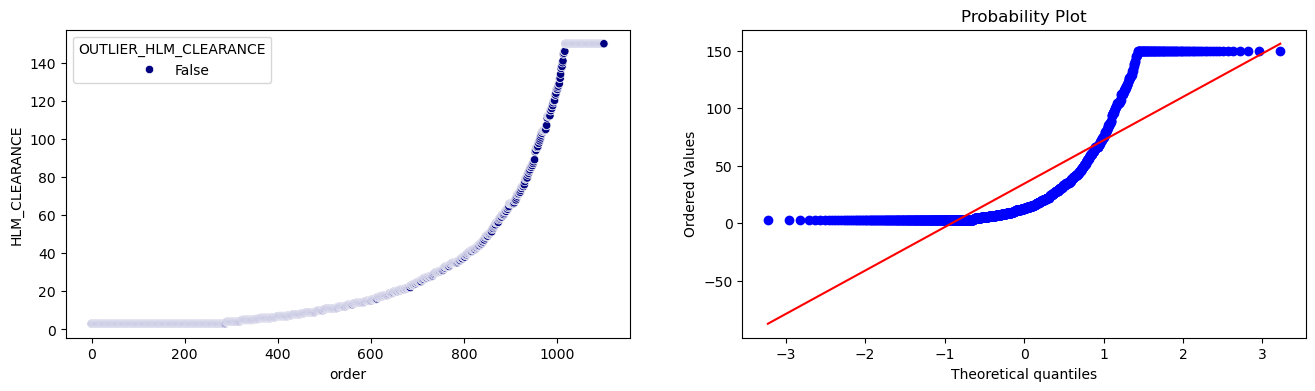

In [9]:
visualize_distribution(dataset=data_look, data_cols=data_cols)

### Re-run curation, removing molecules as needed

In [13]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    keep_all_rows=False,
)

print(f"size before curation: {len(data)}")
data_curated = curator_with_stereo()
print(f"size after curation: {len(data_curated)}")

size before curation: 1102


2024-04-15 14:29:12.361 | WARNING  | polaris.curation._data_curator:run_data_curation:233 - Data types are not provides. We will try our best to determine the types


size after curation: 1102


/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [14]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(
        description="Molecule SMILES string", modality="molecule"
    ),
    "HLM_CLEARANCE": ColumnAnnotation(
        description="Intrinsic clearance measured in human liver microsomes following incubation at 37C.",
        user_attributes={"unit": "uL/min/mg", "organism": "human"},
    ),
}

In [20]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="AstraZeneca_HLM",
    description="Intrinsic clearance measured in human liver microsomes experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301370/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Polaris", slug="polaris"),
    license="CC-BY-SA-4.0",
    user_attributes={"year": "2016"},
    curation_reference="https://github.com/polaris-hub/polaris-recipes/06_AstraZeneca/06_04_AZ_human_HLM_data_curation.ipynb",
)

In [21]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmp4qdbtba7/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmp4qdbtba7/dataset/dataset.json']

In [19]:
folder = "06_AstraZeneca"
data_curated.to_parquet(
    f"gs://polaris-private/curated_datasets/{folder}/{dataset.name}_curated.parquet"
)  # Save just in case. Requires a data folder.

save_dir = f"gs://polaris-private/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

save_dir = f"gs://polaris-public/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

# dataset.upload_to_hub()

/Users/lu.zhu/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


'gs://polaris-public/Datasets/06_AstraZeneca/AstraZeneca_HLM/dataset.json'